In [1]:
import numpy as np
import math
import random
import os
import pybullet as p
import pybullet_data
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import matplotlib.pyplot as plt
import time
import cv2

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, Concatenate
from keras.optimizers import Adam

C:\Users\SERVER\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\SERVER\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\SERVER\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\SERVER\Anaconda3\lib\site-packages\tensorflow\python\framew

In [3]:
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import  SequentialMemory

In [4]:
class BikeEnv(gym.Env):
    
    def __init__(self):
        p.connect(p.GUI)
        p.setRealTimeSimulation(1)
        p.resetDebugVisualizerCamera(cameraDistance=20, cameraYaw=0, cameraPitch=-40, cameraTargetPosition=[0.55,-0.35,0.2])
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Box(np.array([-1000]*10), np.array([1000]*10))
        self.timestep = 1./240.
        
    def step(self, action):

        if (action == 0):
            self.speed = self.speed + 1
        if (action == 1):
            self.speed = self.speed - 1 
        if (action == 2):
            self.speed = self.speed  
        if (action == 3):
            self.steer = self.steer - 1 
        if (action == 4):
            self.steer = self.steer + 1
        if (action == 5):
            self.steer = self.steer 
            
              
        self.applyAction([self.speed,self.steer])
        time.sleep(0.2)
        
        state = p.getLinkState(self.pid,0)[0]
        if state[2] <= 0.5 or  state[2] >= 2 or abs(self.speed)>2 or abs(self.steer)>4:
            reward = -100
            done = True
            
        else :
            #reward = math.sqrt((self.origin[0]-state[0])**2+(self.origin[1]-state[1])**2)
            reward = state[0] - self.origin[0]
            #reward = 1
            done = False
        self.origin = state 
        
        velocity = p.getBaseVelocity(self.pid)
        observation = list(self.getObservation()) + list(velocity[0])+list(velocity[1])
        
        info = {'x':'','y':'','z':''}
        #print("Step: ",self.stp)
        #xx = time.time()
        #print("Time: ",xx-self.tttt)
        #self.tttt = xx
        #print("Action: ",action)
        #print("Reward: ",reward)
        #self.stp +=1
        return observation, reward, done, info
            
    def applyAction(self, motorCommands):
        targetVelocity = motorCommands[0] * self.speedMultiplier
        #print("targetVelocity")
        #print(targetVelocity)
        steeringAngle = motorCommands[1] * self.steeringMultiplier
        #print("steeringAngle")
        #print(steeringAngle)


        for motor in self.motorizedwheels:
            p.setJointMotorControl2(self.pid,
                                    motor,
                                    p.VELOCITY_CONTROL,
                                    targetVelocity=targetVelocity,
                                    force=self.maxForce)
        for steer in self.steeringLinks:
            p.setJointMotorControl2(self.pid,
                                    steer,
                                    p.POSITION_CONTROL,
                                    targetPosition=steeringAngle)

    def reset(self):
        
        #print("===========Reset=====")
        self.stp=0
        self.tttt= time.time()
        p.resetSimulation()

        urdfRootPath = pybullet_data.getDataPath()
        planeUid = p.loadURDF(os.path.join(urdfRootPath,"plane.urdf"), basePosition=[0,0,0])
        
        
        for i in range(np.random.randint(1,100)):
            p.loadURDF(os.path.join(urdfRootPath, "sphere2.urdf"),basePosition=[
                np.random.randint(-10,200),
                np.random.randint(-10,10),
                #np.random.randint(0,2)
                1
            ])
        time.sleep(1)    
        self.pid = p.loadURDF(os.path.join(urdfRootPath, "bicycle/bike.urdf"),basePosition=[0,0,1])
        self.origin = p.getLinkState(self.pid,0)[0]
        p.setGravity(0,0,-10)
        for wheel in range(p.getNumJoints(self.pid)):
            p.setJointMotorControl2(self.pid,
                                    wheel,
                                    p.VELOCITY_CONTROL,
                                    targetVelocity=0,
                                    force=0)

        self.steeringLinks = [0]
        self.maxForce = 20
        self.nMotors = 2
        self.motorizedwheels = [1, 2]
        self.speedMultiplier = 10.
        self.steeringMultiplier = 0.5
        
        self.speed = 0 
        self.steer = 0

        velocity = p.getBaseVelocity(self.pid)
        observation = list(self.getObservation()) + list(velocity[0])+list(velocity[1])
        p.configureDebugVisualizer(p.COV_ENABLE_RENDERING,1)
        return observation
        
    def getObservationDimension(self):
        return len(self.getObservation())
    
    def getObservation(self):
        observation = []
        pos, orn = p.getBasePositionAndOrientation(self.pid)

        #observation.extend(list(pos))
        observation.extend(list(orn))
        return observation
        
    def render(self, mode='human'):
        pos, orn = p.getBasePositionAndOrientation(self.pid)
      
        view_matrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[pos[0]+11.3,pos[1],pos[2]],
                                                            distance=10,
                                                            yaw=-90 ,
                                                            pitch=0,
                                                            roll=0,
                                                            upAxisIndex=2)
        proj_matrix = p.computeProjectionMatrixFOV(fov=60,
                                                     aspect=float(960) /720,
                                                     nearVal=0.1,
                                                     farVal=100.0)
        (_, _, px, _, _) = p.getCameraImage(width=960,
                                              height=720,
                                              viewMatrix=view_matrix,
                                              projectionMatrix=proj_matrix,
                                              renderer=p.ER_BULLET_HARDWARE_OPENGL)

        rgb_array = np.array(px, dtype=np.uint8)
        rgb_array = np.reshape(rgb_array, (720,960, 4))

        rgb_array = rgb_array[:, :, :3]
        return rgb_array

    def close(self):
        p.disconnect()

In [5]:
env = BikeEnv()
np.random.seed(123)
env.seed(123)

C:\Users\SERVER\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
nb_actions = env.action_space.n

In [7]:
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                176       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_3 (Activation)    (None, 16)               

In [8]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [9]:
#dqn.fit(env, nb_steps=50000, visualize=True, verbose=1)

In [10]:
#dqn.save_weights('d:\\RL-DQN-4')

In [11]:
dqn.load_weights('d:\\RL-DQN-4')

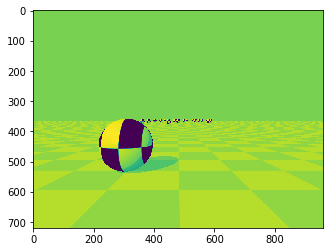

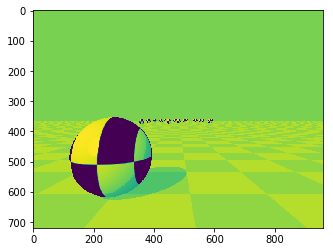

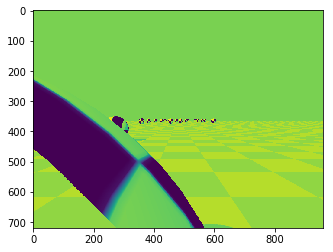

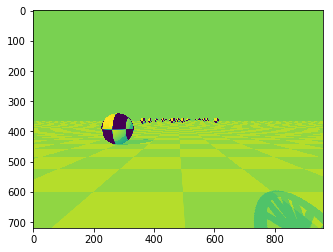

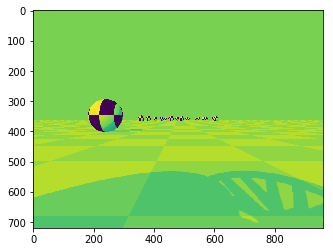

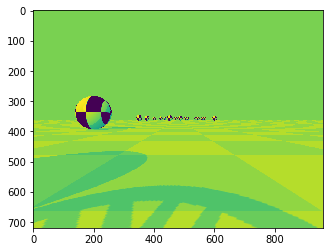

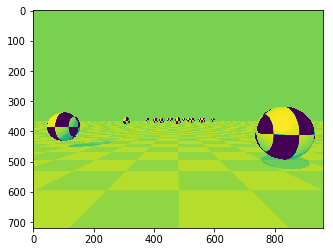

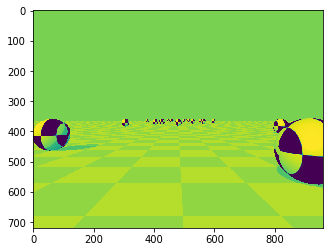

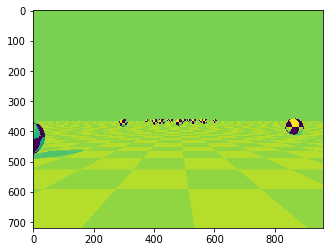

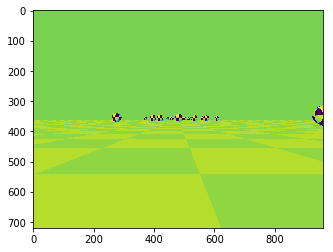

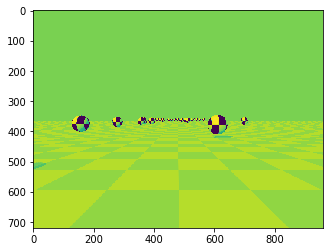

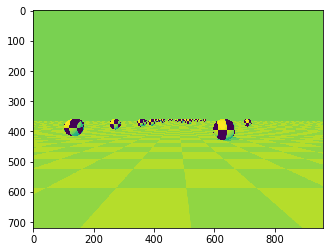

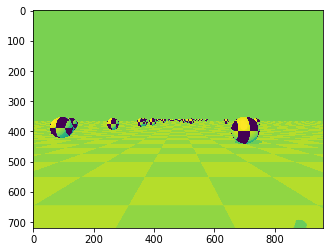

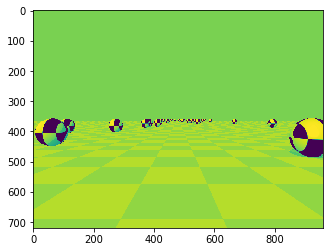

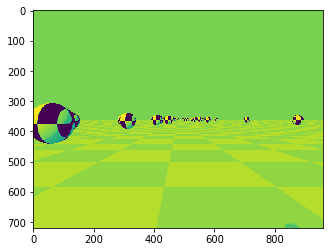

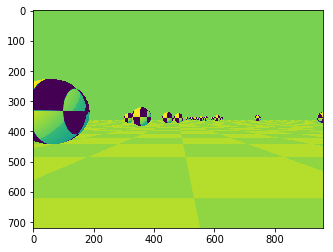

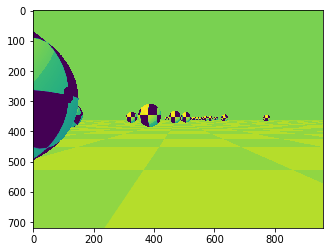

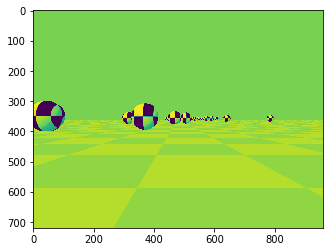

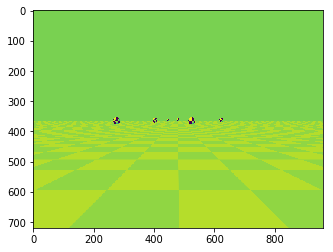

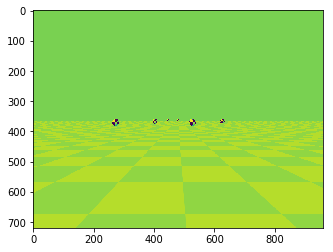

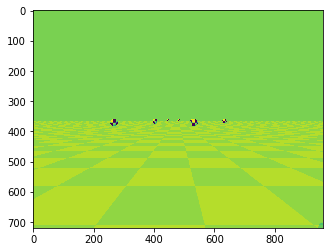

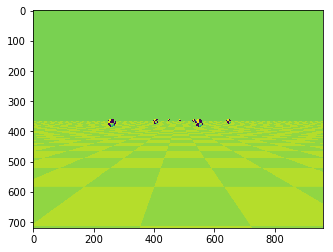

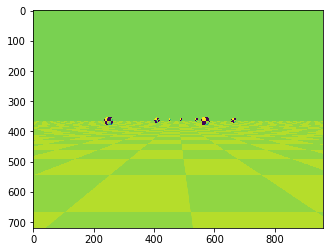

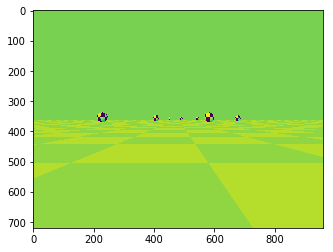

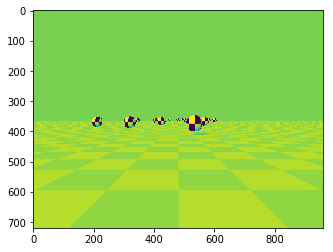

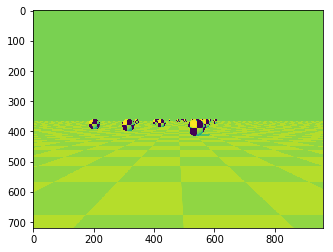

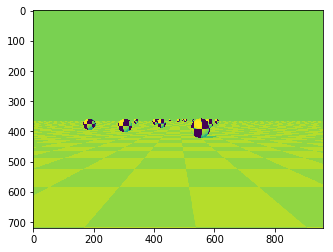

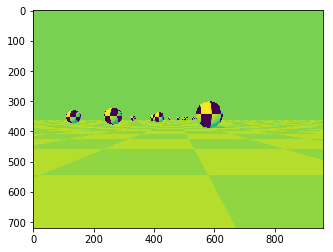

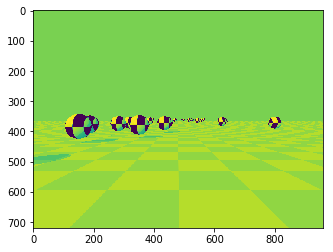

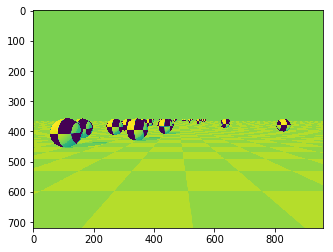

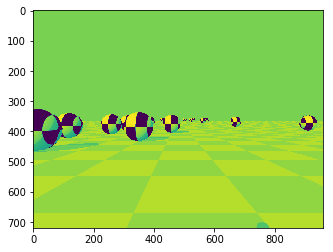

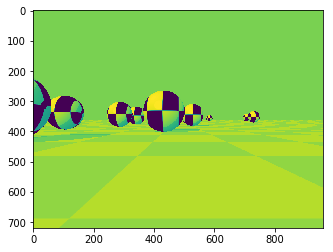

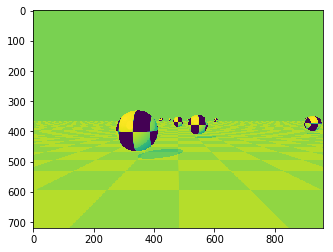

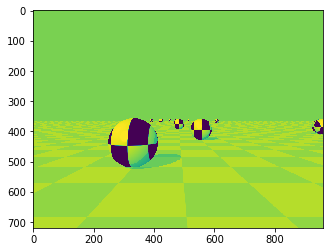

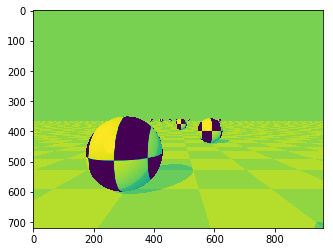

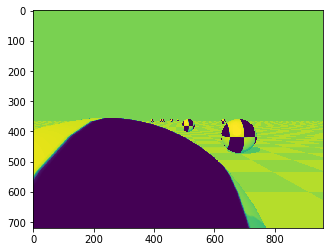

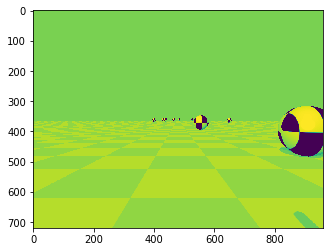

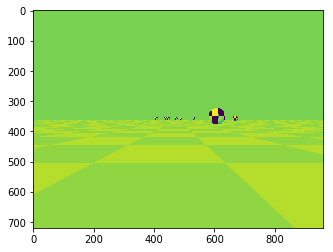

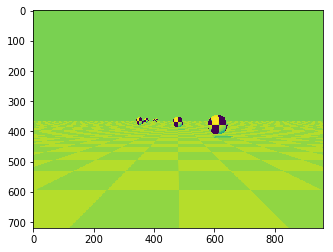

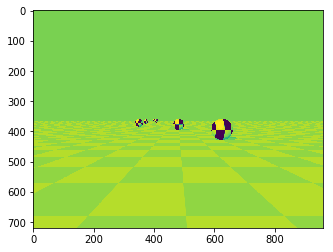

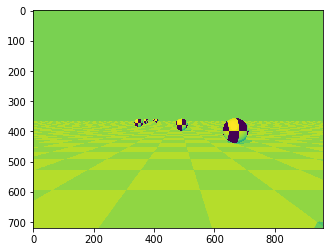

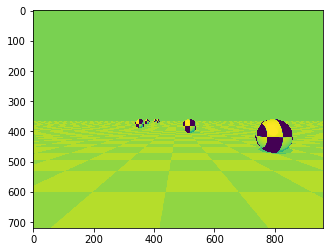

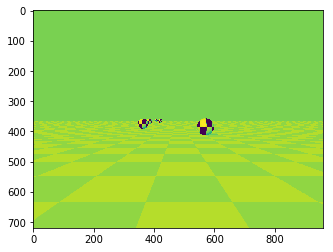

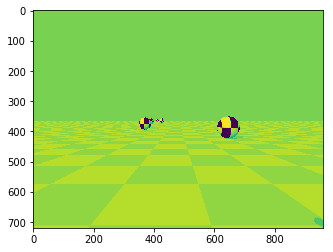

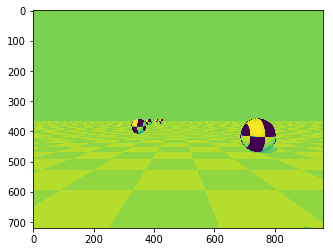

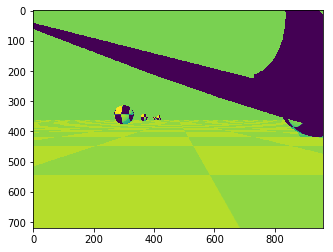

In [ ]:
obsv = env.reset()
x_ = 0
for i in range(100):
    env.render()
    p.resetDebugVisualizerCamera(cameraDistance=20, cameraYaw=1, cameraPitch=-40, cameraTargetPosition=[x_,-0.35,0.2])
    x_ +=1
    action=np.argmax(dqn.model.predict(np.array(obsv).reshape((1,1,10))))
    obsv, _, done, _ =env.step(action)
    img = env.render()
    img2 = cv2.resize(img, (256,256), interpolation = cv2.INTER_NEAREST )
    img2 = img[:,:,2]
    plt.imshow(img2)
    plt.show()
    if done:
        x_ = 0
        obsv = env.reset()
env.close()